<a href="https://colab.research.google.com/github/Sam-Wadmare/ML-LAB/blob/main/lab/sentimetnanalysisi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Accuracy: 0.78

Classification report:

              precision    recall  f1-score   support

           0     0.7800    0.7800    0.7800       200
           1     0.7800    0.7800    0.7800       200

    accuracy                         0.7800       400
   macro avg     0.7800    0.7800    0.7800       400
weighted avg     0.7800    0.7800    0.7800       400



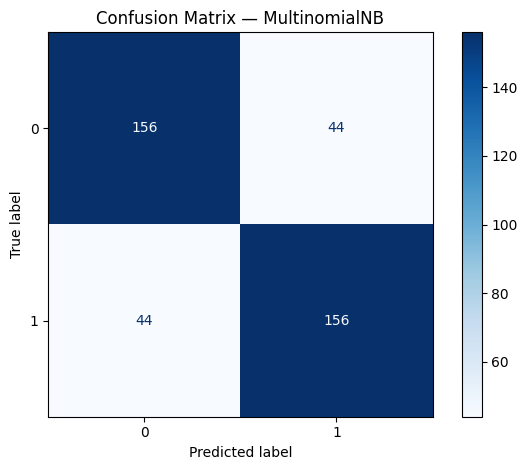


Top words per topic (LDA):
Topic 1: anim, film, stori, disney, movi, voic, joe, like, famili, new
Topic 2: film, movi, charact, like, play, make, time, love, scene, good
Topic 3: film, charact, stori, movi, make, like, time, scene, world, effect
Topic 4: film, movi, like, time, bad, good, charact, make, thing, scene
Topic 5: movi, film, like, action, make, good, scene, charact, time, plot

Saved predictions to exp15_predictions.csv


In [5]:
# exp15_sentiment_single.py
# Minimal single-file script for Experiment 15 — Sentiment Classifier + LDA topics
# Usage: python exp15_sentiment_single.py
%pip install nltk scikit-learn matplotlib pandas

import nltk
from nltk.corpus import movie_reviews
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.decomposition import LatentDirichletAllocation

# -----------------------
# Download required NLTK data
# -----------------------
nltk.download('movie_reviews')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab') # Added to resolve LookupError

# -----------------------
# Load dataset (NLTK movie_reviews)
# -----------------------
docs = []
labels = []
for fid in movie_reviews.fileids():
    docs.append(movie_reviews.raw(fid))
    labels.append(1 if movie_reviews.categories(fid)[0] == 'pos' else 0)

df = pd.DataFrame({'text': docs, 'label': labels})

# -----------------------
# Preprocessing: tokenize, remove stopwords, Porter stemming
# -----------------------
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess(text):
    tokens = word_tokenize(text.lower())
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words]
    stems = [stemmer.stem(t) for t in tokens]
    return " ".join(stems)

df['text_proc'] = df['text'].map(preprocess)

# -----------------------
# Train / Test split
# -----------------------
X = df['text_proc']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# -----------------------
# TF-IDF vectorization
# -----------------------
tfidf = TfidfVectorizer(max_features=8000, ngram_range=(1,2), stop_words='english')
Xtr = tfidf.fit_transform(X_train)
Xte = tfidf.transform(X_test)

# -----------------------
# Train Multinomial Naive Bayes
# -----------------------
clf = MultinomialNB(alpha=1.0)
clf.fit(Xtr, y_train)

# -----------------------
# Predict & Metrics
# -----------------------
y_pred = clf.predict(Xte)
print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("\nClassification report:\n")
print(classification_report(y_test, y_pred, digits=4))

# Confusion Matrix (visual)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.title("Confusion Matrix — MultinomialNB")
plt.tight_layout()
plt.show()

# -----------------------
# Topic modelling (LDA) for insights
# -----------------------
cv = CountVectorizer(max_features=2000, stop_words='english')
X_cv = cv.fit_transform(df['text_proc'])

n_topics = 5
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42, learning_method='batch')
lda.fit(X_cv)

feature_names = cv.get_feature_names_out()
n_top_words = 10
print("\nTop words per topic (LDA):")
for topic_idx, topic in enumerate(lda.components_):
    top_indices = topic.argsort()[::-1][:n_top_words]
    top_words = [feature_names[i] for i in top_indices]
    print(f"Topic {topic_idx+1}: {', '.join(top_words)}")

# -----------------------
# Save predictions (optional)
# -----------------------
out = pd.DataFrame({'text': X_test, 'true': y_test, 'pred': y_pred})
out.to_csv("exp15_predictions.csv", index=False)
print("\nSaved predictions to exp15_predictions.csv")
